In [1]:
%cd ..

C:\Projects\CC-NDP


In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [3]:
from contextlib import suppress

import matplotlib as mpl
from matplotlib.transforms import Bbox
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

from src.classes import Result, RootResult, ProblemData, FORMULATIONS

In [4]:
# For final compilation
mpl.rcParams["text.usetex"] = True
plt.style.use("grayscale")

# Numerical experiments

## Solving experimental instances

In [5]:
experiments = pd.read_csv("instances/test/instances.csv", index_col="name")
experiments.head()

,group,correlation,num_nodes,num_arcs,num_commodities,num_scenarios
name,,,,,,
r04-3-0-128,r04,0.0,10,60,10,128
r04-3-0-256,r04,0.0,10,60,10,256
r04-3-0-512,r04,0.0,10,60,10,512
r04-3-0-16,r04,0.0,10,60,10,16
r04-3-0-32,r04,0.0,10,60,10,32


In [6]:
def make_formulation_perf_measures(df):
    df["run_time"] = df.result.apply(lambda res: res.run_time)
    df["num_iters"] = df.result.apply(lambda res: res.num_iters)
    df["objective"] = df.result.apply(lambda res: res.objective)

    return df


def make_formulation_dataframe(formulations, where):
    data = []
    results = []

    for experiment in experiments.index:
        data_loc = f"instances/test/{experiment}.ndp"
        data.append(
            dict(experiment=experiment, data=ProblemData.from_file(data_loc))
        )

        for formulation in formulations:
            with suppress(FileNotFoundError):
                res = Result.from_file(
                    f"out/{where}/{formulation}/{experiment}.json"
                )
                results.append(
                    dict(
                        experiment=experiment,
                        formulation=formulation,
                        result=res,
                    )
                )

    results = pd.DataFrame.from_records(results).join(
        experiments, on="experiment"
    )
    results = results.merge(pd.DataFrame.from_records(data), on="experiment")

    return make_formulation_perf_measures(results)

In [7]:
results = make_formulation_dataframe(FORMULATIONS, where="new")
# results = results[~results.experiment.str.contains("-3-") & ~results.experiment.str.contains("-6-")]

In [8]:
pvt = pd.pivot(
    index="experiment", columns="formulation", values="run_time", data=results
)
pvt.style.highlight_min(subset=list(FORMULATIONS.keys()), axis=1)

formulation,BB,FlowMIS,MIS,SNC
experiment,,,,
r04-3-0-128,716.802254,71.791445,19.538243,59.087573
r04-3-0-16,109.513687,0.766448,1.200903,3.578642
r04-3-0-256,869.100635,62.532751,84.806200,75.117767
r04-3-0-32,177.121624,3.545082,4.926089,13.588929
r04-3-0-512,2448.811204,142.273457,469.985895,261.219756
r04-3-0-64,290.985402,35.000259,14.168458,33.305556
r04-3-0.2-128,856.254452,21.449528,113.428305,42.697999
r04-3-0.2-16,179.552594,7.245102,12.384859,5.865901
r04-3-0.2-256,948.629634,100.557302,89.910234,72.696225


In [9]:
print(
    pvt.style.highlight_min(
        subset=list(FORMULATIONS.keys()), props="textbf:--rwrap;", axis=1
    )
    .format("{:.0f}", na_rep="OOT")
    .to_latex(hrules=True)
)

\begin{tabular}{lrrrr}
\toprule
formulation & BB & FlowMIS & MIS & SNC \\
experiment &  &  &  &  \\
\midrule
r04-3-0-128 & 717 & 72 & \textbf{20} & 59 \\
r04-3-0-16 & 110 & \textbf{1} & 1 & 4 \\
r04-3-0-256 & 869 & \textbf{63} & 85 & 75 \\
r04-3-0-32 & 177 & \textbf{4} & 5 & 14 \\
r04-3-0-512 & 2449 & \textbf{142} & 470 & 261 \\
r04-3-0-64 & 291 & 35 & \textbf{14} & 33 \\
r04-3-0.2-128 & 856 & \textbf{21} & 113 & 43 \\
r04-3-0.2-16 & 180 & 7 & 12 & \textbf{6} \\
r04-3-0.2-256 & 949 & 101 & 90 & \textbf{73} \\
r04-3-0.2-32 & 251 & 30 & \textbf{13} & 21 \\
r04-3-0.2-512 & 1042 & 262 & \textbf{96} & 510 \\
r04-3-0.2-64 & 326 & 90 & \textbf{6} & 31 \\
r04-6-0-128 & 631 & \textbf{127} & 150 & 170 \\
r04-6-0-16 & 151 & \textbf{11} & 24 & 35 \\
r04-6-0-256 & 1682 & \textbf{250} & 438 & 357 \\
r04-6-0-32 & 335 & 60 & 104 & \textbf{26} \\
r04-6-0-512 & OOT & \textbf{593} & 1270 & 872 \\
r04-6-0-64 & 544 & \textbf{54} & 71 & 167 \\
r04-6-0.2-128 & 466 & 80 & \textbf{74} & 84 \\
r04-6-0.2-16 & 15

In [10]:
results.experiment.groupby(results.formulation).count()  # num solved

formulation
BB         156
FlowMIS    184
MIS        189
SNC        191
Name: experiment, dtype: int64

In [11]:
pvt.idxmin(axis=1).value_counts()  # solved fastest

MIS        69
FlowMIS    67
SNC        32
BB         25
Name: count, dtype: int64

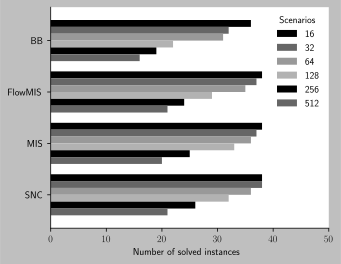

In [12]:
grouped = results.experiment.groupby(
    [results.formulation, results.num_scenarios]
)
ax = grouped.nunique().unstack(1).plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([0, 50])

ax.legend(title="Scenarios", frameon=False, ncol=1)
plt.savefig("out/solved_by_num_scenarios.pdf", transparent=True)

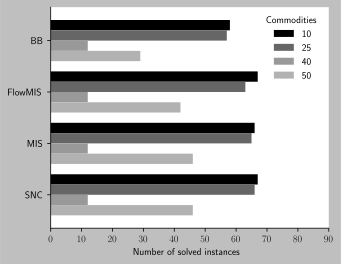

In [13]:
grouped = results.experiment.groupby(
    [results.formulation, results.num_commodities]
)
ax = grouped.nunique().unstack(1).plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([0, 90])

ax.legend(title="Commodities", frameon=False, ncol=1)
plt.savefig("out/solved_by_num_commodities.pdf", transparent=True)

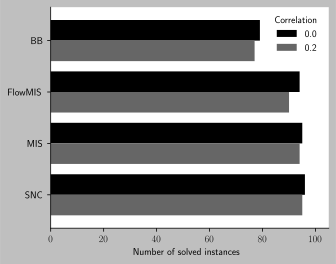

In [14]:
grouped = results.experiment.groupby(
    [results.formulation, results.correlation]
)
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([0, 105])

ax.legend(
    title="Correlation",
    frameon=False,
    ncol=1,
)

plt.savefig("out/solved_by_correlation.pdf", transparent=True)

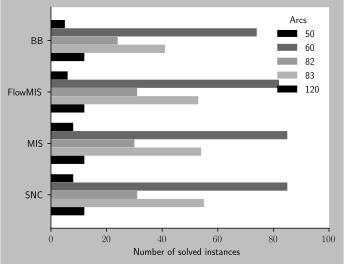

In [15]:
grouped = results.experiment.groupby([results.formulation, results.num_arcs])
ax = grouped.nunique().unstack().plot.barh(figsize=(5, 4), width=0.8)

ax.set_yticklabels(FORMULATIONS.keys())
ax.set_xlabel("Number of solved instances")
ax.set_ylabel("")
ax.invert_yaxis()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_xlim([0, 100])

ax.legend(
    title="Arcs",
    frameon=False,
    ncol=1,
)

plt.savefig("out/solved_by_num_arcs.pdf", transparent=True)

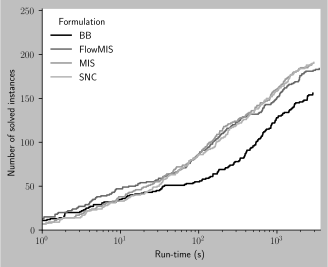

In [16]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_ylabel("Number of solved instances")
ax.set_xlabel("Run-time (s)")

for formulation in FORMULATIONS:
    data = list(sorted(results[results.formulation == formulation].run_time))
    data.insert(0, 0)

    ax.step(
        data,
        np.arange(len(data)),
        where="post",
        label=formulation,
    )

ax.legend(title="Formulation", frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([0, 252])
ax.set_xlim([1, 3_600])

ax.set_xscale("log")

plt.savefig("out/solved_by_runtime.pdf", transparent=True)

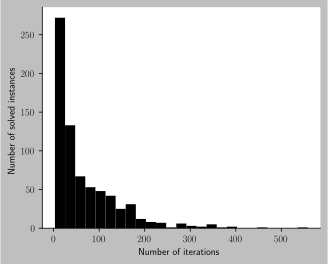

In [17]:
ax = results.plot.hist(
    x="experiment", y="num_iters", bins=25, legend=False, figsize=(5, 4)
)

ax.set_xlabel("Number of iterations")
ax.set_ylabel("Number of solved instances")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig("out/solved_by_num_iters.pdf", transparent=True)

## Single-commodity instances

From theory we have reason to believe FlowMIS works better than other formulations for max-flow (single commodity) instances.
Let's test that!

In [18]:
experiments = pd.read_csv(
    "instances/single-commodity/instances.csv", index_col="name"
)
results = make_formulation_dataframe(FORMULATIONS, where="single-commodity")
results.head()

,experiment,formulation,result,num_nodes,num_arcs,num_commodities,num_scenarios,data,run_time,num_iters,objective
0,r07-3-0-128,BB,Solution results\n================\n # itera...,12,84,1,128,ProblemData\n # nodes: 10\n # arcs:...,192.827172,64,7092.0
1,r07-3-0-128,FlowMIS,Solution results\n================\n # itera...,12,84,1,128,ProblemData\n # nodes: 10\n # arcs:...,13.550913,12,7092.0
2,r07-3-0-128,MIS,Solution results\n================\n # itera...,12,84,1,128,ProblemData\n # nodes: 10\n # arcs:...,1.130826,7,7092.0
3,r07-3-0-128,SNC,Solution results\n================\n # itera...,12,84,1,128,ProblemData\n # nodes: 10\n # arcs:...,1.048614,7,7092.0
4,r07-3-0-16,BB,Solution results\n================\n # itera...,12,84,1,16,ProblemData\n # nodes: 10\n # arcs:...,44.069974,82,10157.0


In [19]:
pvt = pd.pivot(
    index="experiment", columns="formulation", values="run_time", data=results
)
pvt.style.highlight_min(subset=list(FORMULATIONS.keys()), axis=1)

formulation,BB,FlowMIS,MIS,SNC
experiment,,,,
r07-3-0-128,192.827172,13.550913,1.130826,1.048614
r07-3-0-16,44.069974,1.023132,0.493677,0.370346
r07-3-0-256,321.331701,29.752960,2.494017,1.604258
r07-3-0-32,57.069708,2.323835,0.871866,1.037302
r07-3-0-512,672.963418,123.561302,4.240034,3.306072
r07-3-0-64,110.714071,3.176676,3.847031,1.436008
r07-3-0.2-128,177.503903,9.995123,0.828489,0.778744
r07-3-0.2-16,31.633867,0.498203,0.431845,0.425111
r07-3-0.2-256,302.162405,36.840029,2.413976,1.997149


In [20]:
pvt.idxmin(axis=1).value_counts()  # num fastest

SNC        48
FlowMIS    31
MIS        29
Name: count, dtype: int64

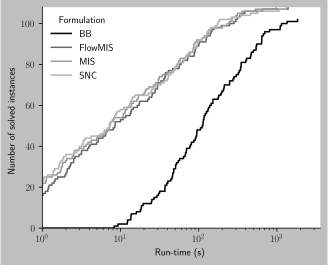

In [21]:
fig, ax = plt.subplots(figsize=(5, 4))

ax.set_ylabel("Number of solved instances")
ax.set_xlabel("Run-time (s)")

for formulation in FORMULATIONS:
    data = list(sorted(results[results.formulation == formulation].run_time))
    data.insert(0, 0)

    ax.step(
        data,
        np.arange(len(data)),
        where="post",
        label=formulation,
    )

ax.legend(FORMULATIONS.keys(), title="Formulation", frameon=False)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylim([0, 108])
ax.set_xlim([1, 3_600])

ax.set_xscale("log")

plt.savefig("out/solved_by_runtime_single_commodity.pdf", transparent=True)